(enrichment-analysis)=

# Gene set enrichment and pathway analysis 
https://www.sc-best-practices.org/conditions/gsea_pathway.html

https://en.wikipedia.org/wiki/Calinski%E2%80%93Harabasz_index

https://en.wikipedia.org/wiki/Dunn_index

https://en.wikipedia.org/wiki/Silhouette_(clustering)#:~:text=The%20silhouette%20score%20is%20specialized,distance%20or%20the%20Manhattan%20distance.

https://nbisweden.github.io/workshop-archive/workshop-scRNAseq/2020-01-27/labs/compiled/scanpy/scanpy_04_clustering.

anndata2ri

## Motivation

Single-cell RNA-seq provides unprecedented insights into variations in cell types between conditions, tissue types, species and individuals. Differential gene expression analysis of the single-cell data is almost always followed by *gene set enrichment analysis*, where the aim is to identify gene programs, such as biological processes, gene ontologies or regulatory pathways that are over-represented in an experimental condition compared to control or other conditions, on the basis of differentially expressed (DE) genes. 

To determine the pathways enriched in a cell type-specific manner between two conditions, first a relevant collection of gene set signatures is selected, where each gene set defines a biological process (e.g. epithelial to mesenchymal transition, metabolism etc) or pathway (e.g. MAPK signalling). For each gene set in the collection, DE genes present in the gene set are used to obtain a test statistic that is then used to assess the enrichment of the gene set. Depending on the type of the enrichment test chosen, gene expression measurements may or may not be used for the computation of the test statistic. 

In this chapter, we first provide an overview of different types of gene set enrichment tests, introduce some commonly used gene signature collections and discuss best practices for pathway enrichment and functional enrichment analysis in general.  We conclude the chapter by demonstrating three analytical approaches for gene set enrichment analysis. Note that we use the terms pathway analysis, pathway enrichment analysis, gene set enrichment analysis and functional analysis interchangeably in this chapter. 

## Pathway and gene set collections

Gene sets are a curated list of gene names (or gene ids) that are known to be involved in a biological process through previous studies and/or experiments. The Molecular Signatures Database (MSigDB) {cite}`subramanian2005gene,liberzon2011molecular` is the most comprehensive database consisting of 9 collections of gene sets. Some commonly used collections are C5, which is the gene ontology (GO) collection, C2 collection of curated gene signatures from published studies that are typically context (e.g. tissue, condition) specific, but also include KEGG and REACTOME gene signatures. For cancer studies, the Hallmark collection is commonly used, and for immunologic studies the C7 collection is a common choice. Note that these signatures are mainly derived from Bulk-seq measurements and measure continuous phenotypes. Recently and with the wide-spread availability of scRNA-seq datasets, databases have evolved that provide curated marker lists derived from published single cell studies that define cell types in various tissues and species. These include CellMarker {cite}`zhang2019cellmarker` and PanglaoDB {cite}`franzen2019panglaodb`. Curated marker lists are not limited to those made available in databases, and can be curated by oneself.

## Null hypotheses in gene set enrichment analysis

Gene set tests can be *competitive* or *self-contained* as defined by Goeman and Buhlmann (2007) {cite}`goeman2007analyzing`. Competitive gene set testing tests whether the genes in the set are highly ranked in terms of differential expression relative to the genes not in the set. The sampling unit here is genes, so the test can be done with a single sample (i.e. single-sample GSEA). The test requires genes that are not in the set (i.e background genes). In self-contained gene set testing, the sampling unit is the subject, so multiple samples per group are required, but it is not required to have genes that are not present in the set. A self-contained gene set test tests whether genes in the test set are differentially expressed without regard to any other gene measured in the dataset. These distinctions between the two null hypotheses make differences to the interpretation of gene set enrichment results. Note that in biological data there exist inter-gene correlations, that is the expression of genes in the same pathways are correlated. There are only a few tests that accomodate inter-gene correlations. We will discuss these methods later. Detailed explanations on various gene set tests can be found in [*limma* user manual](https://bioconductor.org/packages/release/bioc/manuals/limma/man/limma.pdf).

## Gene set tests and pathway analysis

In scRNA-seq data analysis, gene set enrichment is generally carried out on clusters of cells or cell types, one-at-a-time. Genes differentially expressed in a cluster or cell type are used to identify over-represented gene sets from the selected collection, using simple hypergeomtric tests or Fisher's exact test (as in *Enrichr* {cite}`chen2013enrichr`), for example. Such tests do not require the actual gene expression measurements and read counts to compute enrichment statistics, as they rely on testing how significant it is that an $X$ number of genes in a gene set are differentially expressed in the experiment compared to the number of non-DE genes in the set.

*fgsea* {cite}`korotkevich2021fast` is a more common tool for gene set enrichment test. *fgsae* is a computationally faster implementation of the well established *Gene Set Enrichment Analysis (GSEA)* algorithm {cite}`subramanian2005gene`, which computes enrichment statistics on the basis of some preranked gene-level test statistics. *fgsea* computes an enrichment score using some signed statistics of the genes in the gene set, such as  the t-statistics, log fold-changes (logFC) or p-values from the differential expression test. An empirical (estimated from the data) null distribution is computed for the enrichment score using some random gene sets of the same size, and a p-value is computed to determine the significance of the enrichment score. The p-values are then adjusted for multiple hypothesis testing. GSVA {cite}`hanzelmann2013gsva` is another example of preranked gene set enrichment approaches. We should note that the pre-ranked gene set tests are not specific to single cell datasets and apply to Bulk-seq assays as well.

An alternative approach to test for gene set enrichment in a group of cells, that is clusters or cells of identical types, is to create pseudo-bulk samples from single cells and use gene set enrichment methods developed for Bulk RNA-seq. Several self-contained and competitive gene set enrichment tests, namely *fry* and *camera* are implemented in *limma* {cite}`ritchie2015limma`, which are compatible with the differential gene expression analysis framework through linear models and Empirical Bayes moderation of test statistics {cite}`smyth2005limma`. Linear models can accomodate complex experimental designs (e.g. subjects, perturbations, batches, nested contrasts, interactions etc) through the design matrix. In addition, the `camera` and `roast` gene set tests implemented in limma account for inter-gene correlations. Gene set tests in *limma* can also be applied to (properly transformed and normalised) single cell measurements without pseudo-bulk generation. However, there are currently no benchmarks that had assessed the accuracy of gene set test results when these methods are applied directly to single cells.  




| Test | Bulk or SC  | Type of Null Hypothesis | Input |
| :------------ |:---------------:|:----------:| :-------
| Hypergeometric  | both | competitive  | gene counts |
| Fisher's Exact  | both | competitive |  gene counts | 
| GSEA$^*$          | bulk | competitive| gene ranks |
| GSVA$^*$          | bulk | competitive | gene ranks|
| fgsea           | both | competitive | gene ranks |
| fry$^*$             | bulk | self-contained | expression matrix |
| camera$^*$          | bulk | competitive | expression matrix |
| roast$^*$           | bulk | self-contained | expression matrix|

Table: Gene set tests, type of the applicable assays and Null Hypothesis they test

$^*$ These tests are practically applicable to single cell datasets, although their application to single cell may not be a common practice.

### Gene set test vs. pathway activity inference 

Gene set tests test whether a pathway is enriched, in other words over-represented, in one condition compared to others, say, in healthy donors compared to severe COVID-19 patients in the monocyte population. An alternative approach is to simply score the activity of a pathway or gene signature, in absolute sense, in individual cells, rather than testing for a differential activity between conditions. Some of the widely used tools for inference of gene set activity in general (including pathway activity) in individual cells include *VISION* {cite}`detomaso2019functional`, *AUCell* {cite}`aibar2017scenic`, pathway overdispersion analysis using *Pagoda2* {cite}`fan2016characterizing, lake2018integrative` and simple combined z-score {cite}`lee2008inferring`. 

*DoRothEA* {cite}`garcia2019benchmark` and *PROGENy* {cite}`schubert2018perturbation` are among functional analysis tools developed to infer transcription factor (TF) - target activities originally in Bulk RNA data. Holland et al. {cite}`holland2020robustness` found that Bulk RNA-seq methods *DoRothEA* and *PROGENy* have optimal performance in simulated scRNA-seq data, and even partially outperform tools specifically designed for scRNA-seq analysis despite the drop-out events and low library sizes in single cell data. Holland et al. also concluded that pathway and TF activity inference is more sensitive to the choice of gene sets rather than the statistical methods. This observation though can be specific to functional enrichment analyses and be explained by the fact that TF-target relations are context-specific; that is TF-target associations in one cell type may actually differ from another cell type or tissue.  

In contrast to Holand et al., Zhang et al. {cite}`zhang2020benchmarking` found that single-cell-based tools, specifically Pagoda2, outperform bulk-base methods from three different aspects of accuracy, stability and scalability. It should be noted that pathway and gene set activity inference tools inherently do not account for batch effects or biological variations other than the biological variation of interest. Therefore, it is up to the data analyst to ensure that the differential gene expression analysis step has worked properly.

Furthermore, while the tools mentioned here score every gene set in individual cells, they are not able to select for the most biologically relevant gene sets among all scored gene sets. scDECAF (https://github.com/DavisLaboratory/scDECAF) is a gene set activity inference tool that allows data-driven selection of the most informative gene sets, thereby aids in dissecting meaningful cellular heterogeneity.

## Technical considerations

### Filtering out the gene sets with low number of genes 

A common practice is to exclude any gene sets with a few genes overlapping the data or Highly Variable Genes (HVG) in the pre-processing step. Zhang et al. {cite}`zhang2020benchmarking` found that the performance of both single-cell-based and bulk-based methods drops as gene coverage, that is the number of genes in pathways/gene sets, decreases. Holland et al {cite}`holland2020robustness` also found that gene sets of smaller size adversely impacts the performance of Bulk-seq *DoRothEA* and *PROGENy* on single cell data. These report collectively support that filtering gene sets with low gene counts, say less than 10 or 15 genes in the set, is beneficial in pathway analysis. Damian & Gorfine (2004) {cite}`damian2004statistical` attributed this to the fact gene variances in gene sets with a smaller number of genes are more likely to be large, whereas gene variances in larger gene sets tend to be smaller. This impacts the accuracy of the test statistics computed to test for enrichment. Zhang et al. additionally found that pathway analysis was susceptible to normalization procedures applied to gene expression measurements.

### Data normalization

Read counts in single cell experiments are typically normalised early on in the pre-processing pipeline to ensure that measurements are comparable across cells of various library sizes. Zhang et al. {cite}`zhang2020benchmarking` found that normalisation by *SCTransform* {cite}`hafemeister2019normalization` and *scran* {cite}`lun2016step` generally improves the performance of both single-cell- and bulk-based pathway scoring tools. They found that the performance of *AUCell* (a rank-base method) and *z-score* (transformation to zero mean, unit standard deviation) is particularly affected by normalization with distinct methods.

## Case study: Pathway enrichment analysis and activity level scoring in human PBMC single cells

### Prepare and explore the data

We first download the 25K PBMC data and follow the standard `scanpy` workflow for normalisation of read counts and subsetting on the highly variable genes. The dataset contains untreated and IFN-$\beta$ stimulated human PBMC cells {cite}`gspa:kang2018`. We explore patterns of variation in the data with UMAP representation of 4000 highly variable genes. 

In [1]:
from __future__ import annotations

import numpy as np
import pandas as pd

import scanpy as sc
import anndata as ad
import decoupler
import seaborn.objects as so

import session_info

In [2]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

# Filtering warnings from current version of matplotlib
import warnings

warnings.filterwarnings("ignore", message=".*Parameters 'cmap' will be ignored.*", category=UserWarning)
warnings.filterwarnings("ignore", message="Tight layout not applied.*", category=UserWarning)

In [3]:
adata = sc.read("kang_counts_25k.h5ad", backup_url="https://figshare.com/ndownloader/files/34464122")
adata

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

In [4]:
# Storing the counts for later use
adata.layers["counts"] = adata.X.copy()
# Renaming label to condition
adata.obs = adata.obs.rename({"label": "condition"}, axis=1)

# Normalizing
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [5]:
#Finding highly variable genes using count data.
#subset parameter: Inplace subset to highly-variable genes if True otherwise merely indicate highly variable genes.
#This adds var: 'name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm' to adata object.
sc.pp.highly_variable_genes(adata, n_top_genes=4000, flavor="seurat_v3", subset=False, layer="counts")
adata

In [6]:
adata

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

While the current object comes with UMAP and PCA embeddings, these have been corrected for stimulation condition, which we don't want for this analysis. Instead we will recompute these.

In [10]:
#!pip install ipywidgets --upgrade
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

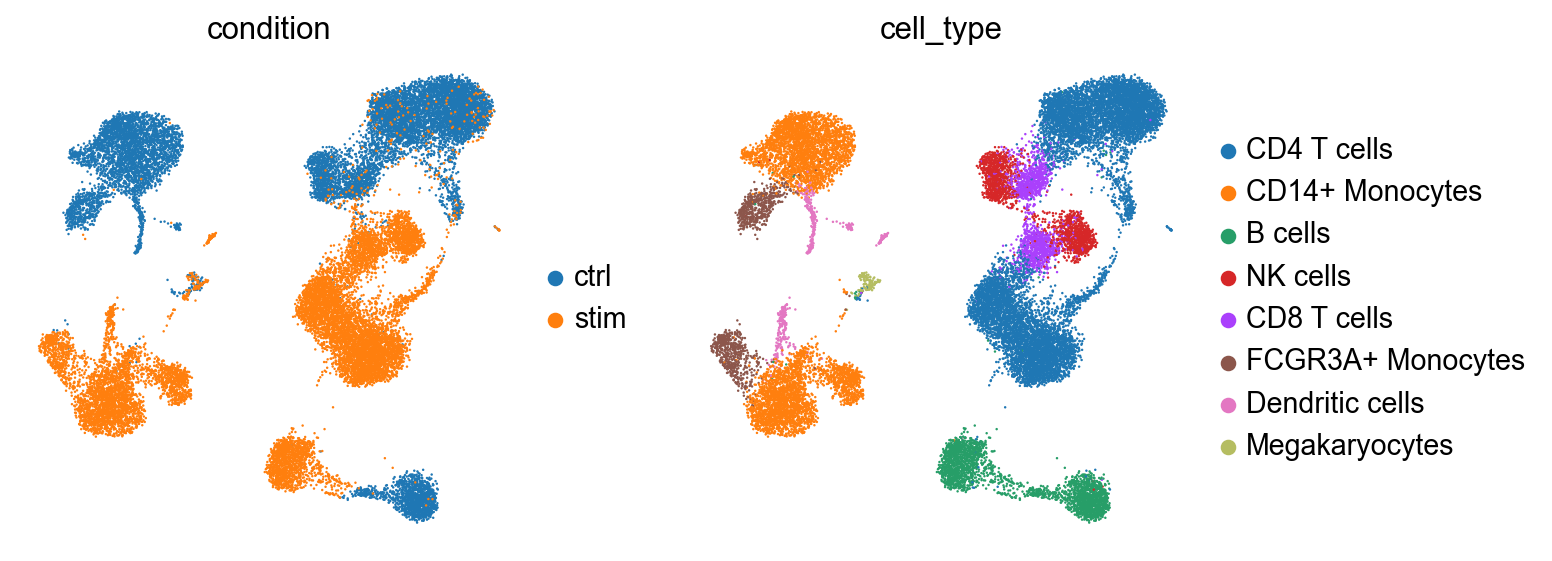

In [11]:
sc.pl.umap(
    adata,
    color=["condition", "cell_type"],
    frameon=False,
    ncols=2,
)

We generally recommend determining the differentially expressed genes as outlined in the `Differential gene expression` chapter. For simplicity, here we run a t-test using `rank_genes_groups` in `scanpy` to rank genes according to their test statistics for differential expression:

In [18]:
adata.obs["group"] = adata.obs.condition.astype("string") + "_" + adata.obs.cell_type

In [19]:
# find DE genes by t-test
sc.tl.rank_genes_groups(adata, "group", method="t-test", key_added="t-test")

Let's extract the ranks for genes differentially expressed in response to IFN stimulation in the CD16 Monocyte (FCGR3A+ Monocytes) cluster. We use these ranks and the gene sets from REACTOME to find gene sets enriched in this cell population compared to all other populations using `GSEA` as implemented in decoupler. 

In [20]:
celltype_condition = "stim_FCGR3A+ Monocytes"  # 'stimulated_B',  'stimulated_CD8 T', 'stimulated_CD14 Mono'

In [21]:
# extract scores
t_stats = (
    # Get dataframe of DE results for condition vs. rest
    sc.get.rank_genes_groups_df(adata, celltype_condition, key="t-test")
    # Subset to highly variable genes
    .set_index("names")
    .loc[adata.var["highly_variable"]]
    # Sort by absolute score
    .sort_values("scores", key=np.abs, ascending=False)
    # Format for decoupler
    [["scores"]]
    .rename_axis(["stim_FCGR3A+ Monocytes"], axis=1)
)
t_stats

stim_FCGR3A+ Monocytes,scores
names,
IFITM3,123.019180
ISG15,119.732079
TYROBP,91.894241
TNFSF10,87.408890
S100A11,85.721817
...,...
NR1D1,-0.005578
PIK3R5,0.004145
FHL2,0.002915


### Cluster-level gene set enrichment analysis with `decoupler`

Now we will use the python package [`decoupler`](https://decoupler-py.readthedocs.io/en/latest/) {cite}`badia2022decoupler` to perform GSEA enrichment tests on our data.

#### Retrieving gene sets

Download and read the `gmt` file for the REACTOME pathways annotated in the C2 collection of MSigDB. 

In [1]:
# Downloading reactome pathways
from pathlib import Path

if not Path("c2.cp.reactome.v7.5.1.symbols.gmt").is_file():
    !wget -O 'c2.cp.reactome.v7.5.1.symbols.gmt' https://figshare.com/ndownloader/files/35233771

SYSTEM_WGETRC = c:/progra~1/wget/etc/wgetrc
syswgetrc = c:\Program Files (x86)\GnuWin32/etc/wgetrc
--2024-06-13 00:42:26--  https://figshare.com/ndownloader/files/35233771
Resolving figshare.com... 52.209.10.53, 54.229.254.236
Connecting to figshare.com|52.209.10.53|:443... connected.
OpenSSL: error:1407742E:SSL routines:SSL23_GET_SERVER_HELLO:tlsv1 alert protocol version
Unable to establish SSL connection.


In [6]:
def gmt_to_decoupler(pth: Path) -> pd.DataFrame:
    """
    Parse a gmt file to a decoupler pathway dataframe.
    """
    from itertools import chain, repeat

    pathways = {}

    with Path(pth).open("r") as f:
        for line in f:
            name, _, *genes = line.strip().split("\t")
            pathways[name] = genes

    return pd.DataFrame.from_records(
        chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()),
        columns=["geneset", "genesymbol"],
    )

In [7]:
reactome = gmt_to_decoupler("c2.cp.reactome.v7.5.1.symbols.gmt")

Alternatively, we could just query for these resources from omnipath.

However, for stability of this tutorial we are using a fixed version of the gene set collection.

```python
# Retrieving via python
msigdb = decoupler.get_resource("MSigDB")

# Get reactome pathways
reactome = msigdb.query("collection == 'reactome_pathways'")
# Filter duplicates
reactome = reactome[~reactome.duplicated(("geneset", "genesymbol"))]
```

In [8]:
reactome

,geneset,genesymbol
0,REACTOME_INTERLEUKIN_6_SIGNALING,JAK2
1,REACTOME_INTERLEUKIN_6_SIGNALING,TYK2
2,REACTOME_INTERLEUKIN_6_SIGNALING,CBL
3,REACTOME_INTERLEUKIN_6_SIGNALING,STAT1
4,REACTOME_INTERLEUKIN_6_SIGNALING,IL6ST
...,...,...
89471,REACTOME_ION_CHANNEL_TRANSPORT,FXYD7
89472,REACTOME_ION_CHANNEL_TRANSPORT,UBA52
89473,REACTOME_ION_CHANNEL_TRANSPORT,ATP6V1E2
89474,REACTOME_ION_CHANNEL_TRANSPORT,ASIC5


#### Running GSEA

First we'll prepare our gene sets. By default `decoupler` will not filter gene sets by maximum size, which packages like `fgsea` do. Instead we will simply manually filter gene sets to have a minimum of 15 genes and a maximum of 500 genes.

In [9]:
# Filtering genesets to match behaviour of fgsea
geneset_size = reactome.groupby("geneset").size()
gsea_genesets = geneset_size.index[(geneset_size > 15) & (geneset_size < 500)]

We'll use the t-statistics from the t-test to rank the genes for the CD16 Monocyte phenotype upon IFN stimulation and computes p-values for each of the pathways.

In [22]:
scores, norm, pvals = decoupler.run_gsea(
    t_stats.T,
    reactome[reactome["geneset"].isin(gsea_genesets)],
    source="geneset",
    target="genesymbol",
)

gsea_results = (
    pd.concat({"score": scores.T, "norm": norm.T, "pval": pvals.T}, axis=1)
    .droplevel(level=1, axis=1)
    .sort_values("pval")
)

We make a bar plot of top 20 pathways significantly enriched in stimulated CD16 Monocytes compared to all other cell types.

c:\Users\user\Documents\GitHub\PathSingle\venv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


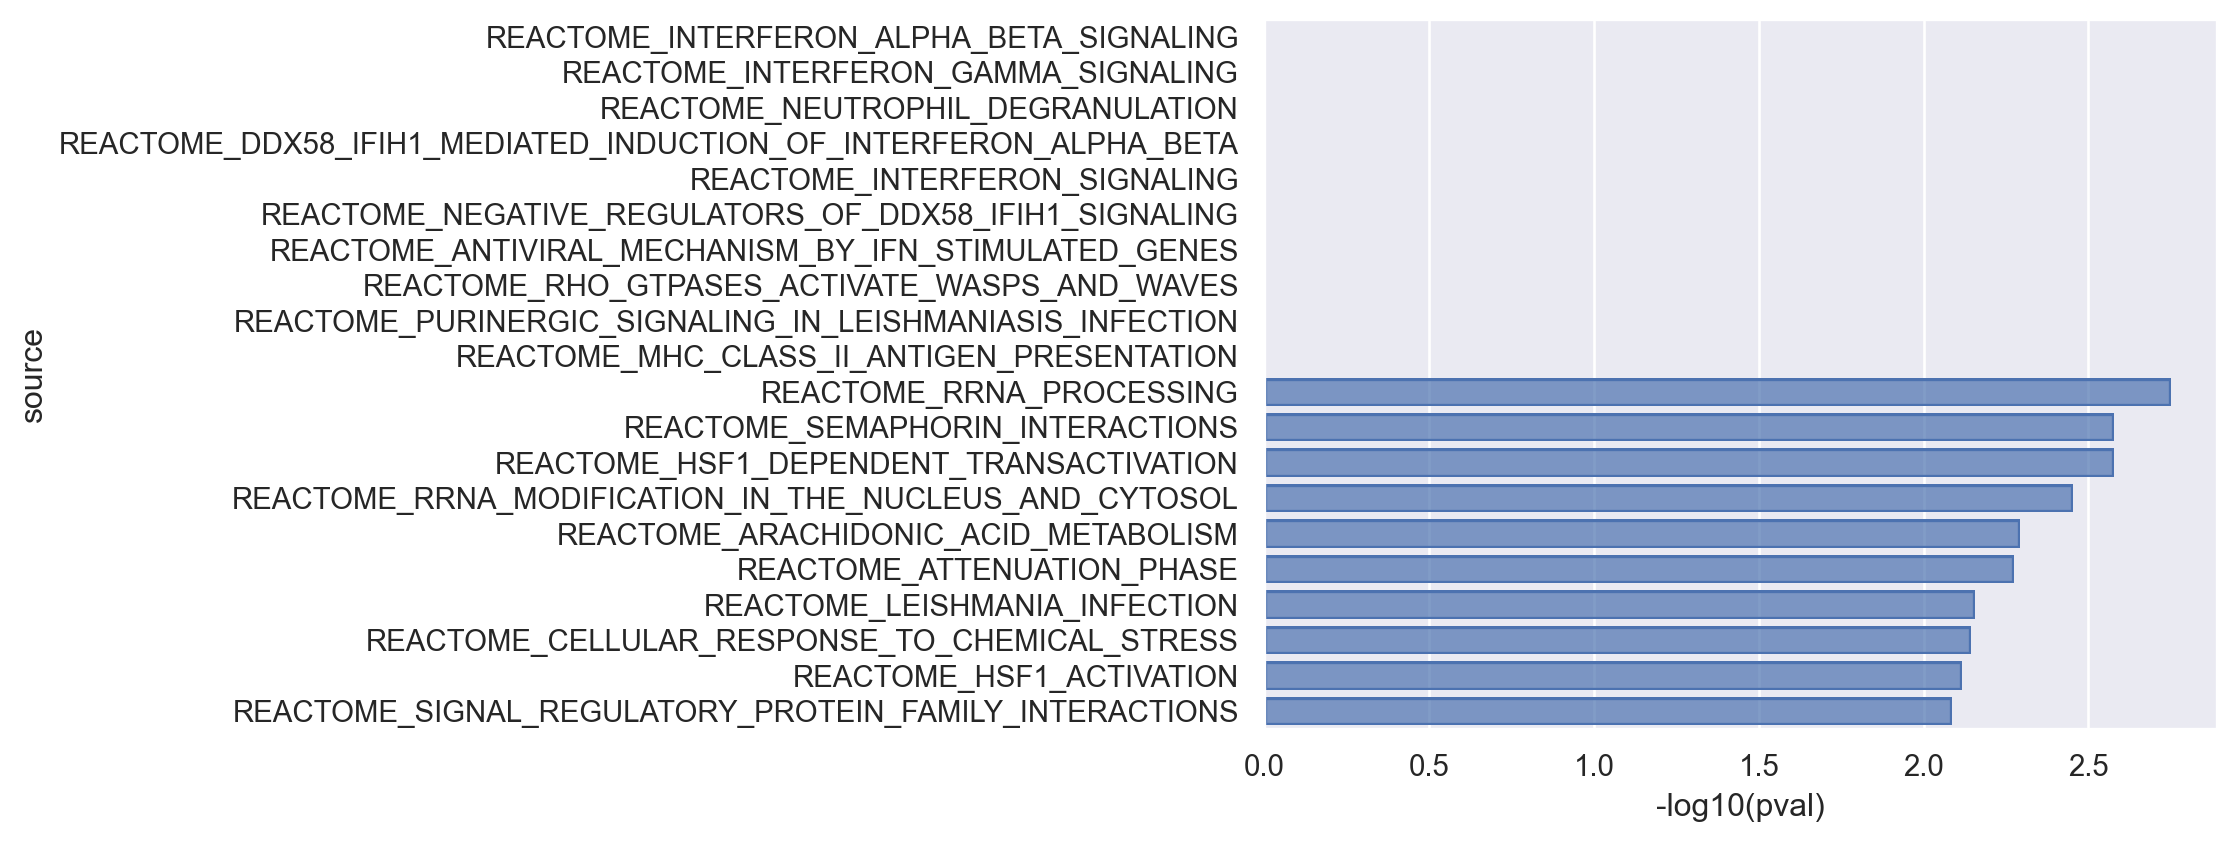

In [23]:
(
    so.Plot(
        data=(
            gsea_results.head(20).assign(
                **{"-log10(pval)": lambda x: -np.log10(x["pval"])}
            )
        ),
        x="-log10(pval)",
        y="source",
    ).add(so.Bar())
)

In the plot above, pathway names are given in the y-axis. The x-axis describes the $-\log_{10}$adjusted p-values. Therefore, the longer the height of the bar, the more significant the pathway is. Pathways are ordered by significance. The majority of interferon-related pathways are indeed ranked among the top 20 most significantly enriched pathways. Some IFN-related pathways include, REACTOME_INTERFERON_SIGNALING (ranked 2nd), REACTOME_INTERFERON_GAMMA_SIGNALING (ranked 3rd), and REACTOME_INTERFERON_ALPHA_BETA_SIGNALING (ranked 4th). Overall, `GSEA` did a decent job in identifying the pathways known to be associated with interferon signalling, given that we know a priori that IFN-related pathways should be the top-ranked terms.

Let's look at the raw output of `decoupler.run_gsea`:

In [24]:
gsea_results.head(10)

,score,norm,pval
source,,,
REACTOME_INTERFERON_ALPHA_BETA_SIGNALING,0.893431,2.366431,0.0
REACTOME_INTERFERON_GAMMA_SIGNALING,0.831962,2.335520,0.0
REACTOME_NEUTROPHIL_DEGRANULATION,0.624770,2.287297,0.0
REACTOME_DDX58_IFIH1_MEDIATED_INDUCTION_OF_INTERFERON_ALPHA_BETA,0.766464,1.981579,0.0
REACTOME_INTERFERON_SIGNALING,0.844159,2.662881,0.0
REACTOME_NEGATIVE_REGULATORS_OF_DDX58_IFIH1_SIGNALING,0.861492,1.904688,0.0
REACTOME_ANTIVIRAL_MECHANISM_BY_IFN_STIMULATED_GENES,0.808242,2.105454,0.0
REACTOME_RHO_GTPASES_ACTIVATE_WASPS_AND_WAVES,0.899143,1.761635,0.0
REACTOME_PURINERGIC_SIGNALING_IN_LEISHMANIASIS_INFECTION,0.787365,1.846134,0.0


In above, `pval` is the p-value for the enrichment test, while `score` and `norm` are enrichment scores and normalized enrichment scores respectively. Note that enrichment scores are signed. Therefore, a negative scores suggests the pathway is down-regulated and a positive score is indicative of up-regulation of genes in the pathway or gene set.

### Cell-level pathway activity scoring using AUCell

Unlike the previous approach where we assessed gene set *enrichment* per *cluster* (or rather cell type), one can *score* the activity level of pathways and gene sets in each individual cell, that is based on absolute gene expression in the cell, regardless of expression of genes in the other cells. This we can achieve by activity scoring tools such as `AUCell`.

Similar to `GSEA`, we will be using the `decoupler` implementation of `AUCell`.

In [25]:
%%time
decoupler.run_aucell(
    adata,
    reactome,
    source="geneset",
    target="genesymbol",
    use_raw=False,
)

CPU times: total: 13min 8s
Wall time: 12min 17s


In [26]:
adata

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'group'
    var: 'name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'condition_colors', 'cell_type_colors', 't-test'
    obsm: 'X_pca', 'X_umap', 'aucell_estimate'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

We now add the scores for the interferon-related REACTOME pathways to the `obs` field of the `AnnData` object and annotate the activity level of these pathways in each of the cells on the UMAP:

In [27]:
ifn_pathways = [
    "REACTOME_INTERFERON_SIGNALING",
    "REACTOME_INTERFERON_ALPHA_BETA_SIGNALING",
    "REACTOME_INTERFERON_GAMMA_SIGNALING",
]

adata.obs[ifn_pathways] = adata.obsm["aucell_estimate"][ifn_pathways]

Plot the scores on the umap

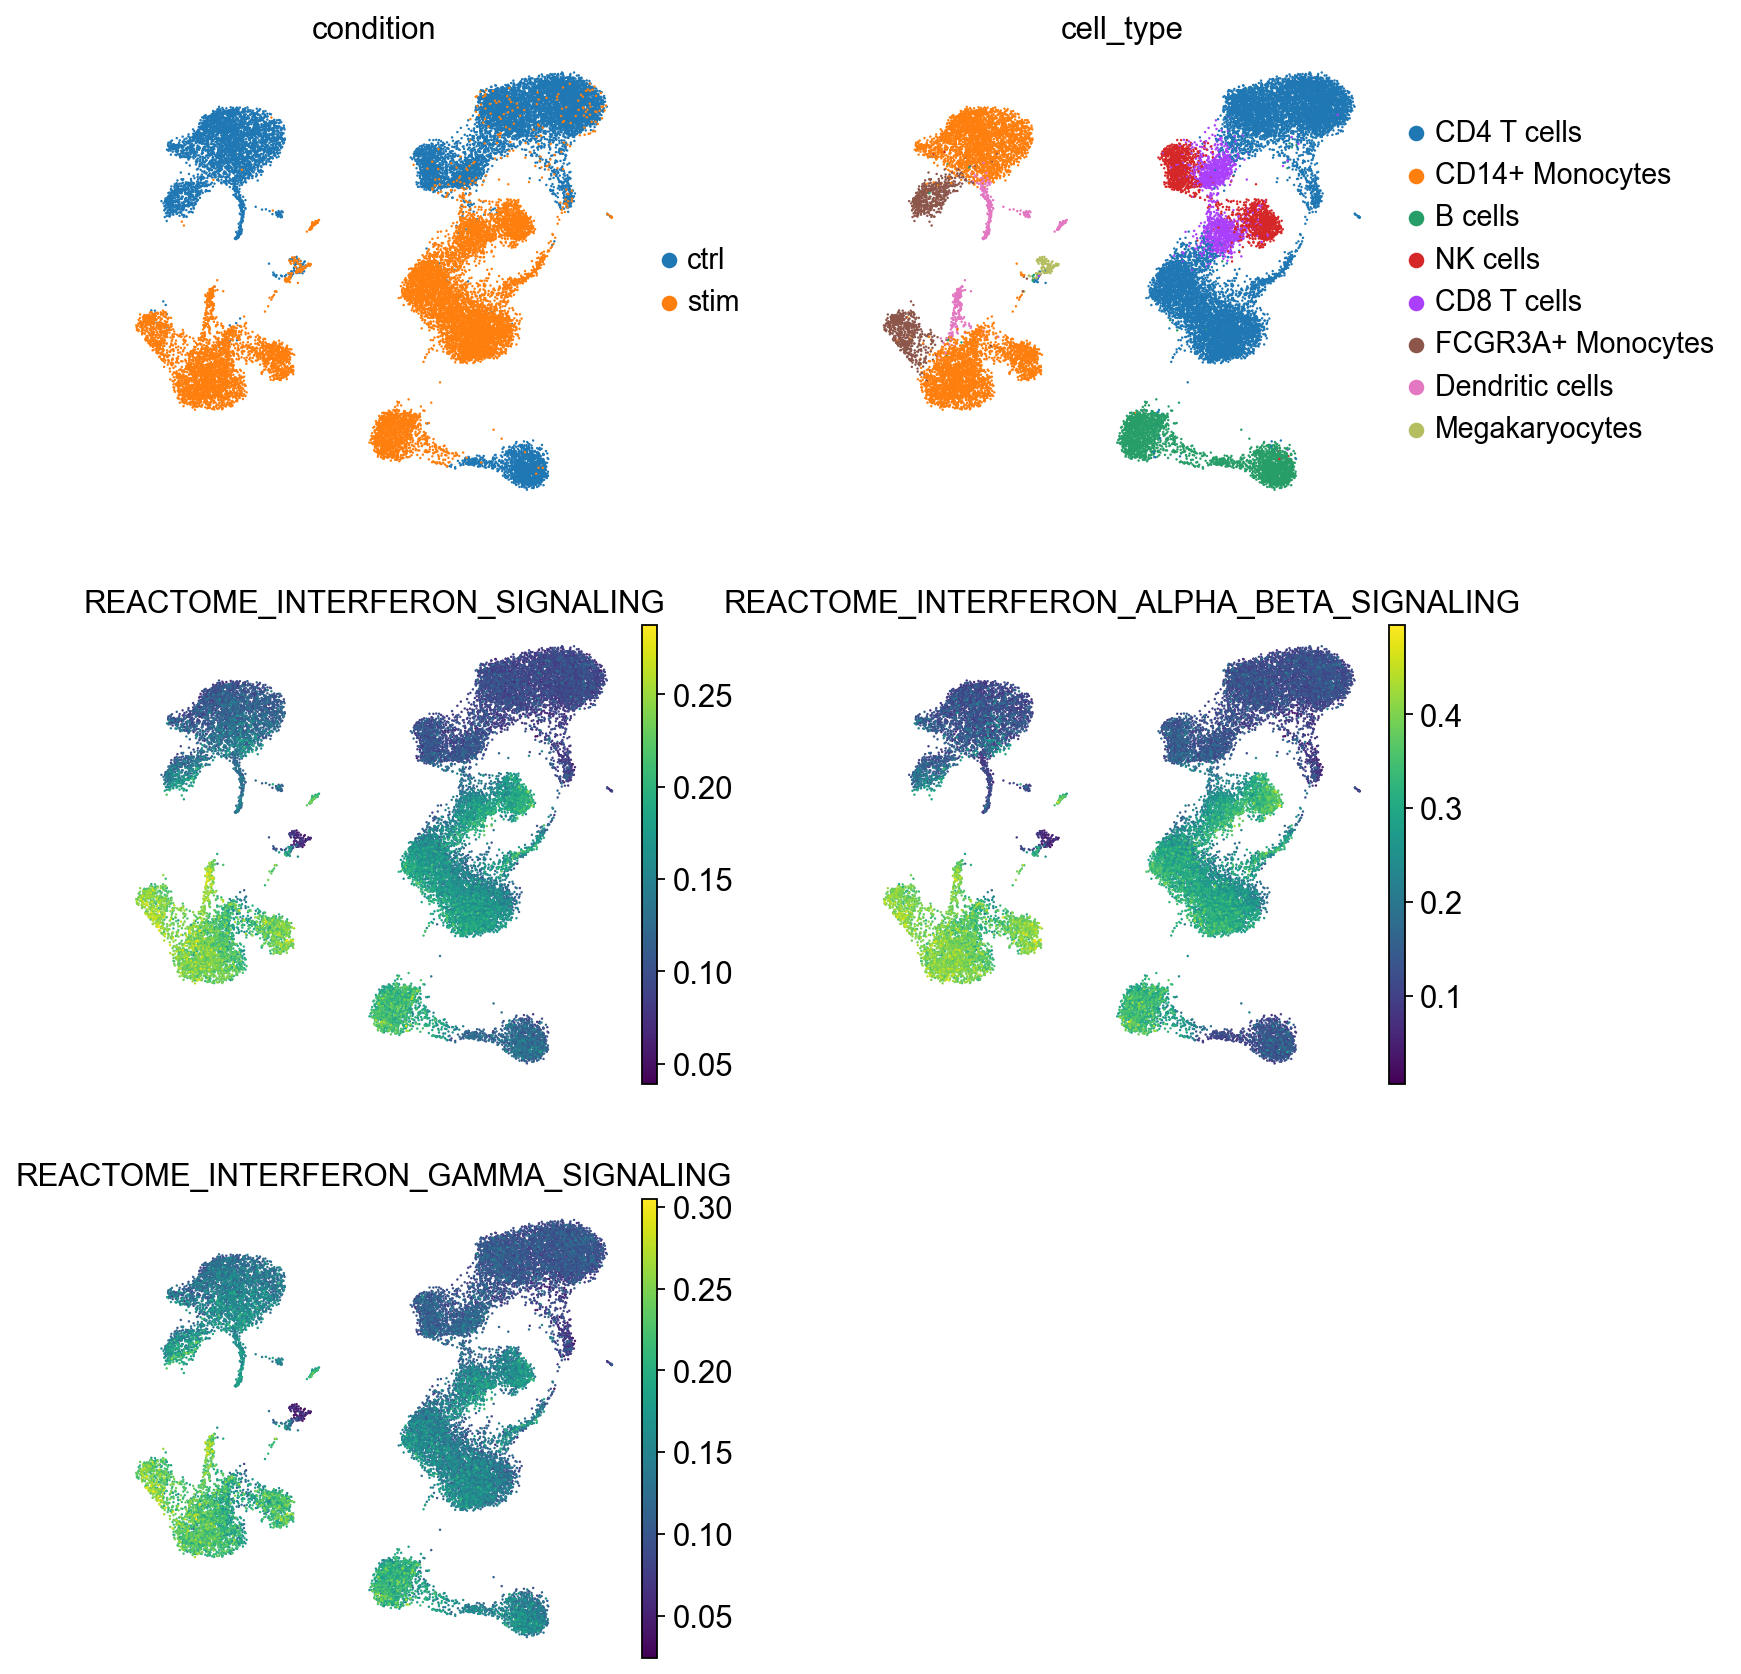

In [28]:
sc.pl.umap(
    adata,
    color=["condition", "cell_type"] + ifn_pathways,
    frameon=False,
    ncols=2,
    wspace=0.3,
)

`AUCell` scores the pathways well-known to be implicated in interferon signalling high in IFN-stimulated cells, while cells in the control condition generally have low scores for these pathways, demonstrating that gene set scoring with `AUCell` has been successful. Also note that the scores are generally larger for terms that are ranked higher in the gene set enrichment test results by `GSEA`. The concordance between pathway activity scores by `AUCell` and gene set enrichment test by `GSEA` is promising, given that we know a priori that IFN-related pathways should be the top-ranked terms. In addition, the effect of IFN stimulation is very large in this dataset and this contributes to the performance of the methods here. 

### Gene set enrichment for complex experimental designs using limma-fry and pseudo-bulks

In cluster-level t-test approach, differentially expressed genes are found by comparing a cluster to all other clusters, which in this case includes both control and stimulated cells. Linear models allow us to compare cells in the stimulated condition only to those in the control group, resulting in more accurate identification of genes responding to the stimulus. Indeed, linear models can accommodate for complex experimental designs, for example, identification of gene sets enriched in `Cell type A in treatment 1` compared to `Cell type A in treatment 2`; that is, across perturbation and across cell types effects, while adjusting for batch effects, between-individual variations, gender and strain differences in mouse models etc. 

In the next section, we demonstrate a limma-fry workflow that generalize to realistic data analysis routines, say, for single-cell case control studies. We first create pseudo-bulk replicates per cell type and condition (3 replicates per condition - cell type combination). We then find gene sets enriched in stimulated compared to control cells in a cell type. We also assess gene set enrichment between two stimulated cell type populations to find differences in signalling pathways. 

In [ ]:
# Setting up R dependencies. Make sure R_HOME is set up as environment variable.
try:
    import rpy2.robjects as robjects
except OSError as e:
    try:
        import os
        import platform
        import ctypes
        if ('Windows') in platform.system():
            os.environ["R_HOME"] = 'C:\\Program Files\\R-4.4.0'  # Your R version here 'R-4.0.3'
            os.environ["PATH"] = "C:\\Program Files\\R-4.4.0\\bin\\x64" + ";" + os.environ["PATH"]
            Dll = ctypes.WinDLL('C:\\Program Files\\R-4.4.0\\bin\\x64\R.dll')
            Dll2 = ctypes.WinDLL('C:\\Program Files\\R-4.4.0\\library\\stats\\libs\\x64\\stats.dll')
            Dll3 = ctypes.WinDLL('C:\\Program Files\\R-4.4.0\\library\\matrixStats\\libs\\x64\\matrixStats.dll')
        import rpy2.robjects as robjects
    except OSError:
        raise(e)

import anndata2ri
#import rpy2
from rpy2.robjects import r
import random

%load_ext rpy2.ipython

anndata2ri.activate()

In [ ]:
#R package matrixStats is required for the following cell.
%%R
suppressPackageStartupMessages({
    library(SingleCellExperiment)
})

#### Create pseudo-bulk samples and explore the data

In [28]:
def subsampled_summation(
    adata: ad.AnnData,
    groupby: str | list[str],
    *,
    n_samples_per_group: int,
    n_cells: int,
    random_state: None | int | np.random.RandomState = None,
    layer: str = None,
) -> ad.AnnData:
    """
    Sum sample of X per condition.

    Drops conditions which don't have enough samples.

    Parameters
    ----------
    adata
        AnnData to sum expression of
    groupby
        Keys in obs to groupby
    n_samples_per_group
        Number of samples to take per group
    n_cells
        Number of cells to take per sample
    random_state
        Random state to use when sampling cells
    layer
        Which layer of adata to use

    Returns
    -------
    AnnData with same var as original, obs with columns from groupby, and X.
    """
    from scipy import sparse
    from sklearn.utils import check_random_state

    # Checks
    if isinstance(groupby, str):
        groupby = [groupby]
    random_state = check_random_state(random_state)

    indices = []
    labels = []

    grouped = adata.obs.groupby(groupby)
    for k, inds in grouped.indices.items():
        # Check size of group
        if len(inds) < (n_cells * n_samples_per_group):
            continue

        # Sample from group
        condition_inds = random_state.choice(
            inds, n_cells * n_samples_per_group, replace=False
        )
        for i, sample_condition_inds in enumerate(np.split(condition_inds, 3)):
            if isinstance(k, tuple):
                labels.append((*k, i))
            else:  # only grouping by one variable
                labels.append((k, i))
            indices.append(sample_condition_inds)

    # obs of output AnnData
    new_obs = pd.DataFrame.from_records(
        labels,
        columns=[*groupby, "sample"],
        index=["-".join(map(str, l)) for l in labels],
    )
    n_out = len(labels)

    # Make indicator matrix
    indptr = np.arange(0, (n_out + 1) * n_cells, n_cells)
    indicator = sparse.csr_matrix(
        (
            np.ones(n_out * n_cells, dtype=bool),
            np.concatenate(indices),
            indptr,
        ),
        shape=(len(labels), adata.n_obs),
    )

    return ad.AnnData(
        X=indicator @ sc.get._get_obs_rep(adata, layer=layer),
        obs=new_obs,
        var=adata.var.copy(),
    )

In [29]:
pb_data = subsampled_summation(
    adata, ["cell_type", "condition"], n_cells=75, n_samples_per_group=3, layer="counts"
)
pb_data

AnnData object with n_obs × n_vars = 42 × 15706
    obs: 'cell_type', 'condition', 'sample'
    var: 'name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'

In [30]:
# Does PC1 captures a meaningful biological or technical fact?
pb_data.obs["lib_size"] = pb_data.X.sum(1)

Let's normalize this data and take a quick look at it. We won't use a neighbor embedding here since the sample size is significantly reduced.

In [31]:
pb_data.layers["counts"] = pb_data.X.copy()

In [32]:
sc.pp.normalize_total(pb_data)
sc.pp.log1p(pb_data)
sc.pp.pca(pb_data)

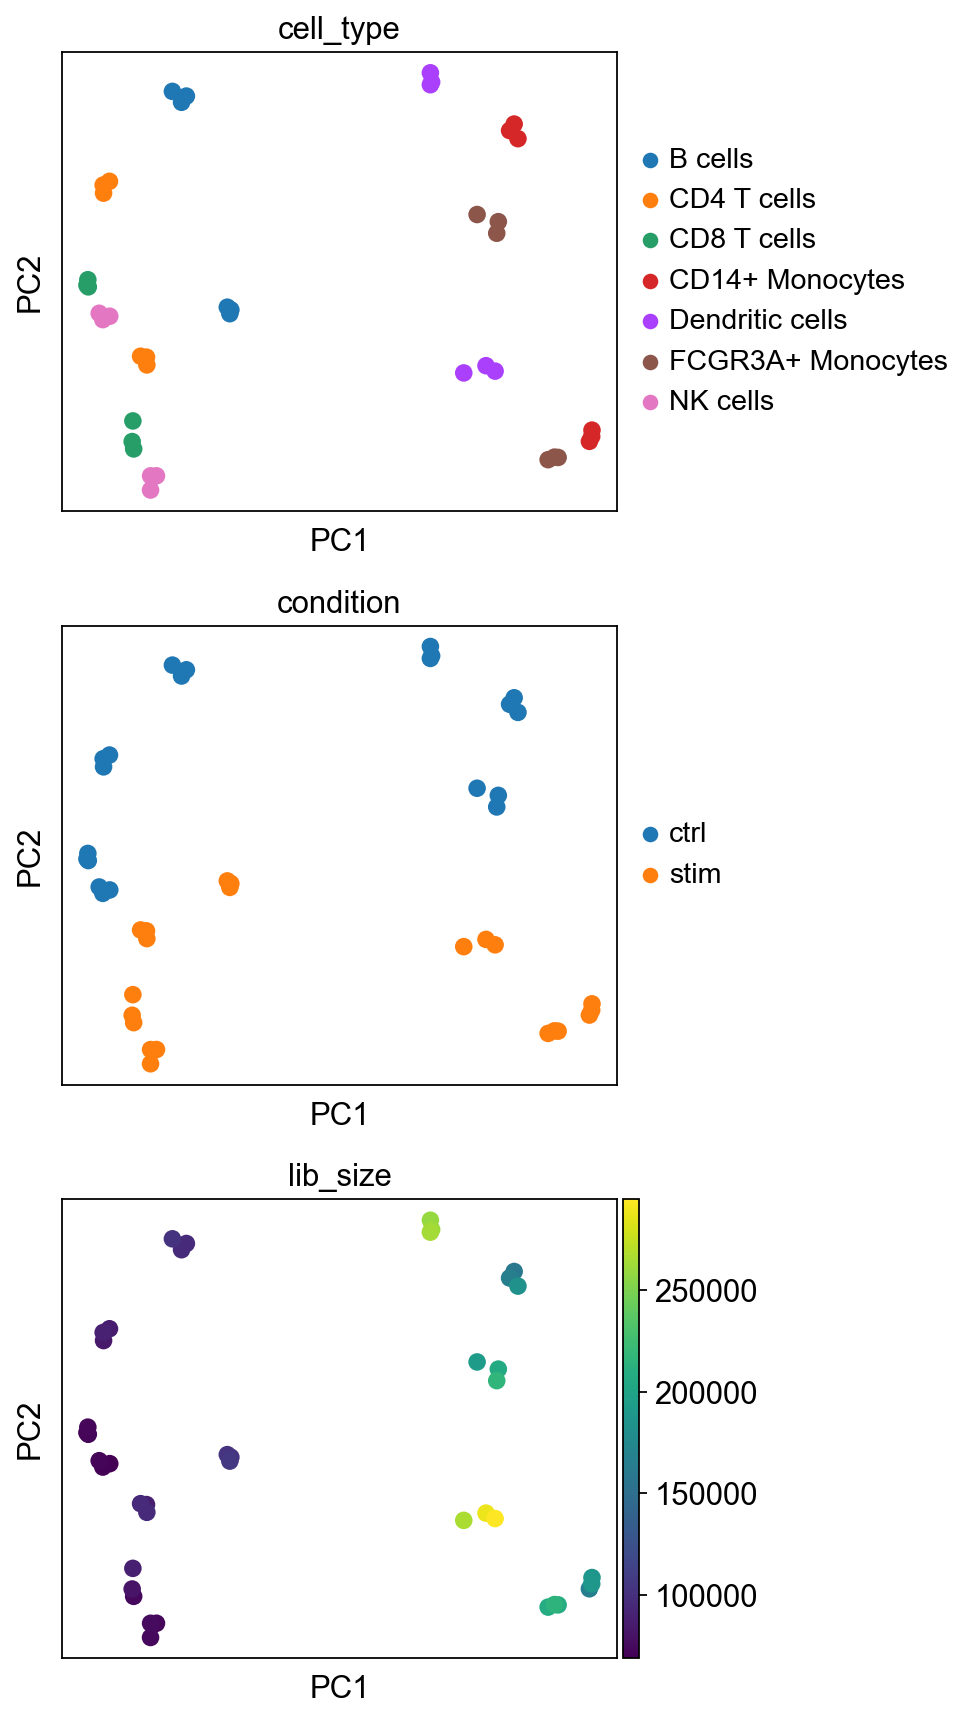

In [33]:
sc.pl.pca(pb_data, color=["cell_type", "condition", "lib_size"], ncols=1, size=250)

PC1 now captures difference between lymphoid (T, NK, B) and myeloid (Mono, DC) populations, while the second PC captures variation due to administration of stimulus (i.e. difference between control and stimulated pseduo-replicates). Ideally, the variation of interest has to be detectable in top few PCs of the pseudo-bulk data. 

In this case, since we are indeed interested in stimulation effect per cell type, we proceed to gene set testing. We re-iterate that the purpose of plotting PCs is to explore various axes of variability in the data and to spot unwanted variabilities that can substantial influence the test results. Users may proceed with the rest of the analyses should they be satisfied with the the variations in their data.

#### Setup for `limma` and `fry`

For this next part of the analysis we will be using Bioconductor packages `limma` and it's method `fry`.

We first set up the design and contrast matrices. Let's remind ourselves that a design matrix is a mathematical representation of group membership (i.e. the group or condition to which a sample belongs), and contrast matrices are mathematical representations of comparisons of interest for the differential test.

In [34]:
groups = pb_data.obs.condition.astype("string") + "_" + pb_data.obs.cell_type

In [35]:
%%R -i groups
group <-  as.factor(gsub(" |\\+","_", groups))
design <- model.matrix(~ 0 + group)
head(design)

     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11] [,12] [,13] [,14]
[1,]    0    0    1    0    0    0    0    0    0     0     0     0     0     0
[2,]    0    0    1    0    0    0    0    0    0     0     0     0     0     0
[3,]    0    0    1    0    0    0    0    0    0     0     0     0     0     0
[4,]    0    0    0    0    0    0    0    0    0     1     0     0     0     0
[5,]    0    0    0    0    0    0    0    0    0     1     0     0     0     0
[6,]    0    0    0    0    0    0    0    0    0     1     0     0     0     0


In [36]:
%%R
colnames(design)

 [1] "groupctrl_B_cells"           "groupctrl_CD14__Monocytes"  
 [3] "groupctrl_CD4_T_cells"       "groupctrl_CD8_T_cells"      
 [5] "groupctrl_Dendritic_cells"   "groupctrl_FCGR3A__Monocytes"
 [7] "groupctrl_NK_cells"          "groupstim_B_cells"          
 [9] "groupstim_CD14__Monocytes"   "groupstim_CD4_T_cells"      
[11] "groupstim_CD8_T_cells"       "groupstim_Dendritic_cells"  
[13] "groupstim_FCGR3A__Monocytes" "groupstim_NK_cells"         


In [37]:
%%R 
kang_pbmc_con <- limma::makeContrasts(
    
    # the effect if stimulus in CD16 Monocyte cells
    groupstim_FCGR3A__Monocytes - groupctrl_FCGR3A__Monocytes,
    
    # the effect of stimulus in CD16 Monocytes compared to CD8 T Cells
    (groupstim_FCGR3A__Monocytes - groupctrl_FCGR3A__Monocytes) - (groupstim_CD8_T_cells - groupctrl_CD8_T_cells), 
    levels = design
)

Index the genes annotated in each pathway in our data as follows:

In [38]:
log_norm_X = pb_data.to_df().T

In [39]:
%%R -i log_norm_X -i reactome
# Move pathway info from python to R
pathways = split(reactome$genesymbol, reactome$geneset)
# Map gene names to indices
idx = limma::ids2indices(pathways, rownames(log_norm_X))

/Users/isaac/miniconda3/envs/pathway/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/Users/isaac/miniconda3/envs/pathway/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


As done in the `gsea` method, let's remove gene sets with less than 15 genes

In [40]:
%%R
keep_gs <- lapply(idx, FUN=function(x) length(x) >= 15)
idx <- idx[unlist(keep_gs)]

Now that we have set up the design and contrast matrices, and have indexed the genes in each pathway in our data, we can call `fry()` to test for enriched pathways in each of the contrasts we set above:

#### fry test for Stimulated vs Control

In [41]:
%%R -o fry_results
fry_results <- limma::fry(log_norm_X, index = idx, design = design, contrast = kang_pbmc_con[,1])

Taking a look at the top ranked pathways we'll see some familiar names:

In [42]:
fry_results.head()

,NGenes,Direction,PValue,FDR,PValue.Mixed,FDR.Mixed
REACTOME_INTERFERON_ALPHA_BETA_SIGNALING,57,Up,3.836198e-24,3.410380e-21,8.018820e-39,9.504975e-38
REACTOME_INTERFERON_SIGNALING,177,Up,5.651011e-18,2.511875e-15,3.888212e-51,1.047461e-49
REACTOME_INTERFERON_GAMMA_SIGNALING,84,Up,6.080234e-13,1.801776e-10,4.268886e-61,2.710743e-59
REACTOME_MRNA_SPLICING_MINOR_PATHWAY,50,Down,8.311795e-11,1.847296e-08,5.137952e-20,2.003351e-19
REACTOME_DDX58_IFIH1_MEDIATED_INDUCTION_OF_INTERFERON_ALPHA_BETA,67,Up,1.555236e-09,2.765210e-07,9.966640e-53,3.055291e-51


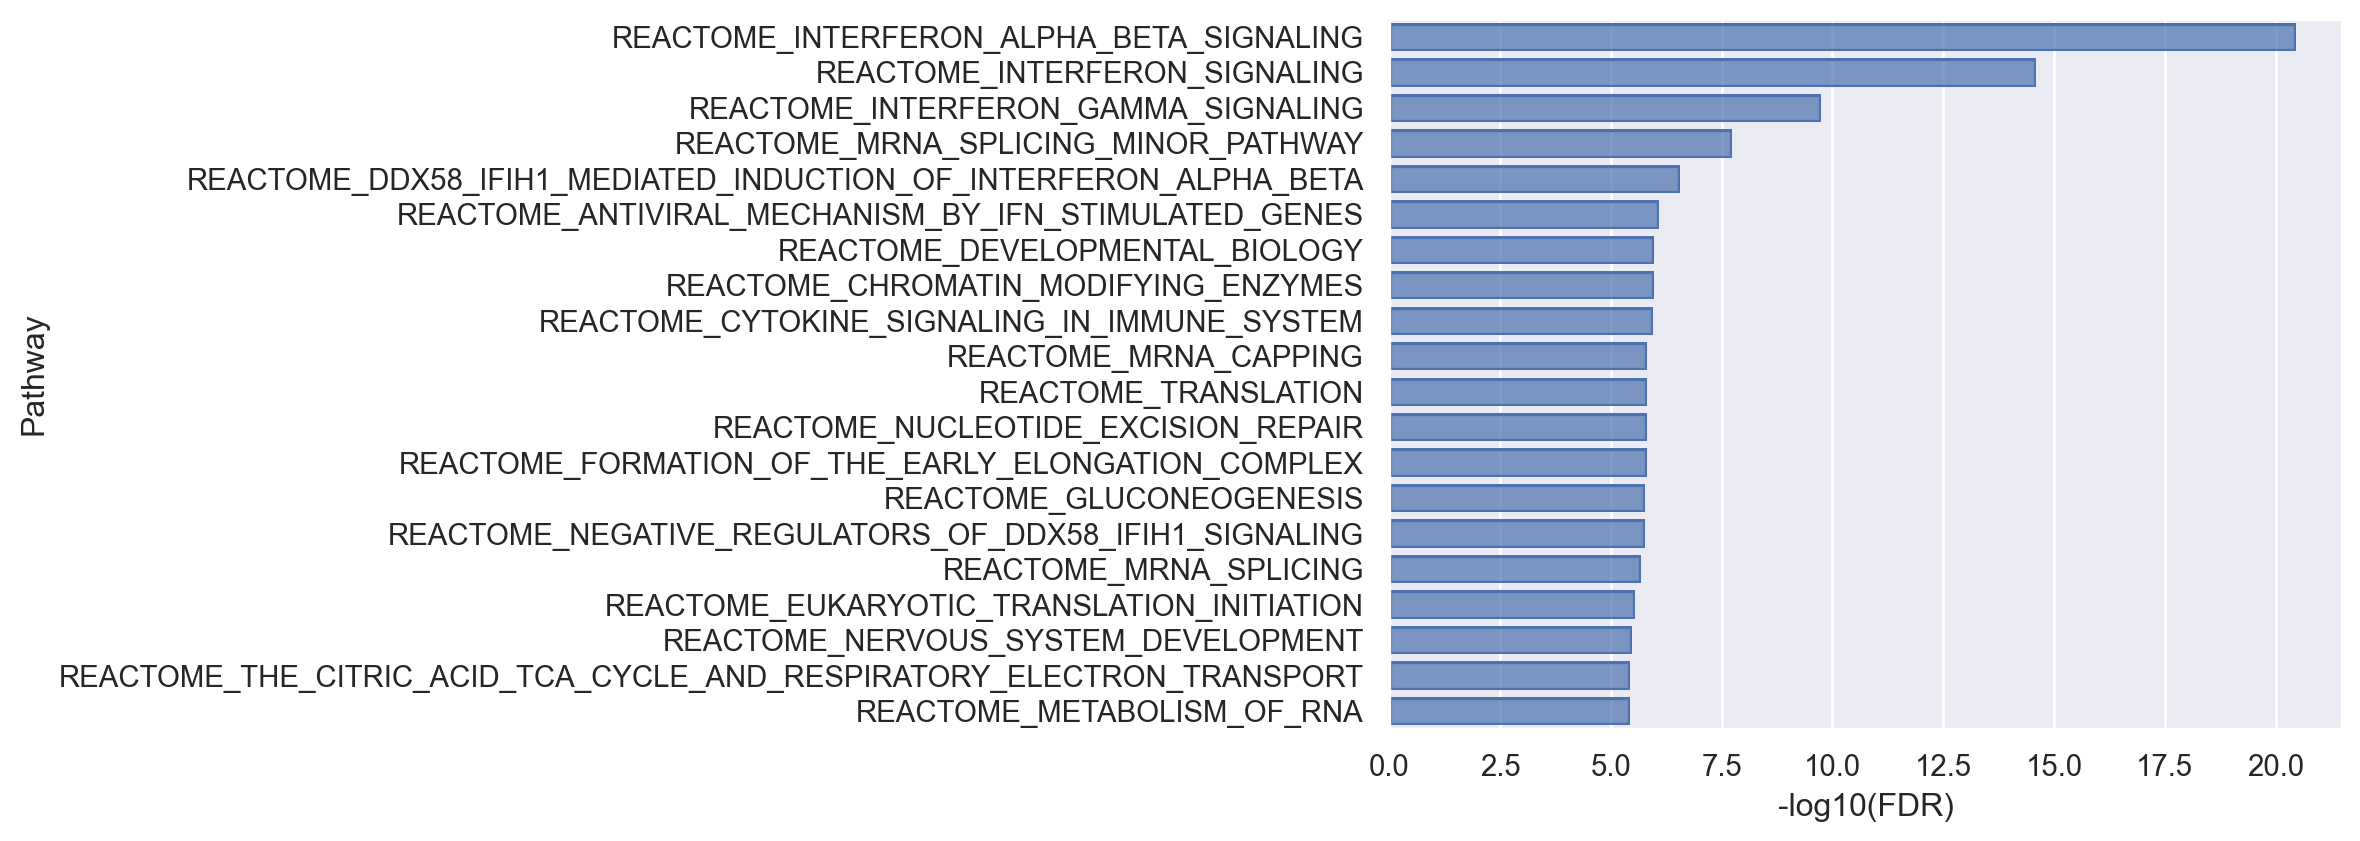

In [43]:
(
    so.Plot(
        data=(
            fry_results.head(20)
            .assign(**{"-log10(FDR)": lambda x: -np.log10(x["FDR"])})
            .rename_axis(index="Pathway")
        ),
        x="-log10(FDR)",
        y="Pathway",
    ).add(so.Bar())
)

#### fry test for the comparison between two stimulated cell types

In [44]:
%%R -o fry_results_negative_ctrl
fry_results_negative_ctrl <- limma::fry(log_norm_X, index = idx, design = design, contrast = kang_pbmc_con[,2])

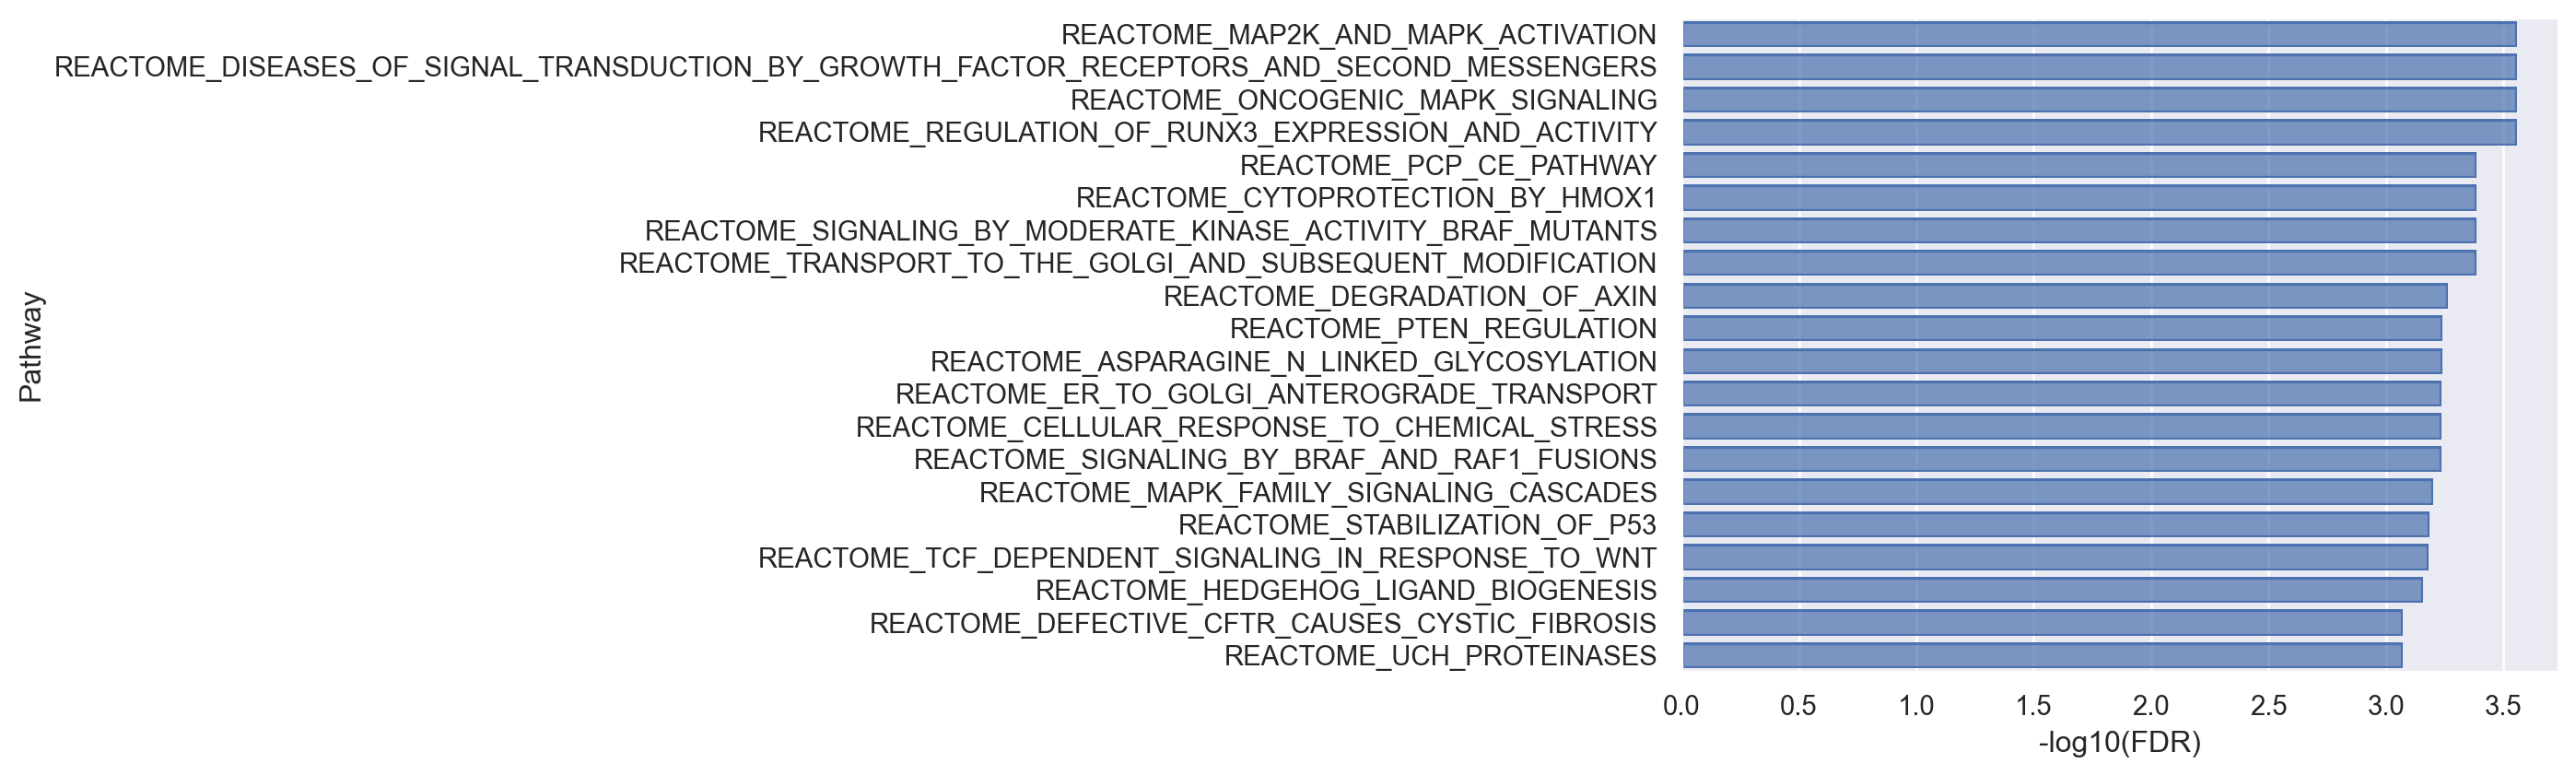

In [45]:
(
    so.Plot(
        data=(
            fry_results_negative_ctrl.head(20)
            .assign(**{"-log10(FDR)": lambda x: -np.log10(x["FDR"])})
            .rename_axis(index="Pathway")
        ),
        x="-log10(FDR)",
        y="Pathway",
    ).add(so.Bar())
)

As demonstrated above, limma-fry can accomodate gene set enrichment tests for datasets and research problems with complex experimental designs. Both `gsea` and `fry` provide insights into the direction of enrichment (positive or negative score in `gsea` and Direction field in `fry`). They both can be applied to clusters of cells or pseudo-bulk samples. However,  Unlike `gsea`, more flexible tests can be carried out with `fry`. In addition, `fry` can reveal if genes in a pathway are changing between the experimental conditions but in consistent or inconsistent directions. Pathways in which the genes change in consistent direction are identified with `FDR` < 0.05. Pathways in which the genes are DE between the conditions but they change in different, inconsistent directions can be identified where `FDR` > 0.05, but `FDR.Mixed` < 0.05 (assuming 0.05 is the desired significance level). `fry` is bidirectional, applicable to arbitrary designs and works well with small number of samples (although this may not be an issue in single cell). Therefore, the results by `fry` might be of more interest biologically. 

##### On the effect of  filtering low-expression genes

As mentioned before, Ideally, the variation of interest has to be detectable in top few PCs of the pseudo-bulk data. 
Let's remove genes with low expression in the data, apply $\log_2$CPM transformation and repeat the PCA plots:

In [46]:
counts_df = pb_data.to_df(layer="counts").T

In [47]:
%%R -i counts_df
keep <- edgeR::filterByExpr(counts_df) # in real analysis, supply the desig matrix to the function to retain as more genes as possible
counts_df <- counts_df[keep,]
logCPM <- edgeR::cpm(counts_df, log=TRUE, prior.count = 2)

/Users/isaac/miniconda3/envs/pathway/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
R[write to console]: No group or design set. Assuming all samples belong to one group.



In [48]:
%%R -o logCPM
logCPM = data.frame(logCPM)

In [49]:
pb_data.uns["logCPM_FLE"] = logCPM.T  # FLE for filter low exprs

In [50]:
pb_data.obsm["logCPM_FLE_pca"] = sc.pp.pca(logCPM.T.to_numpy(), return_info=False)

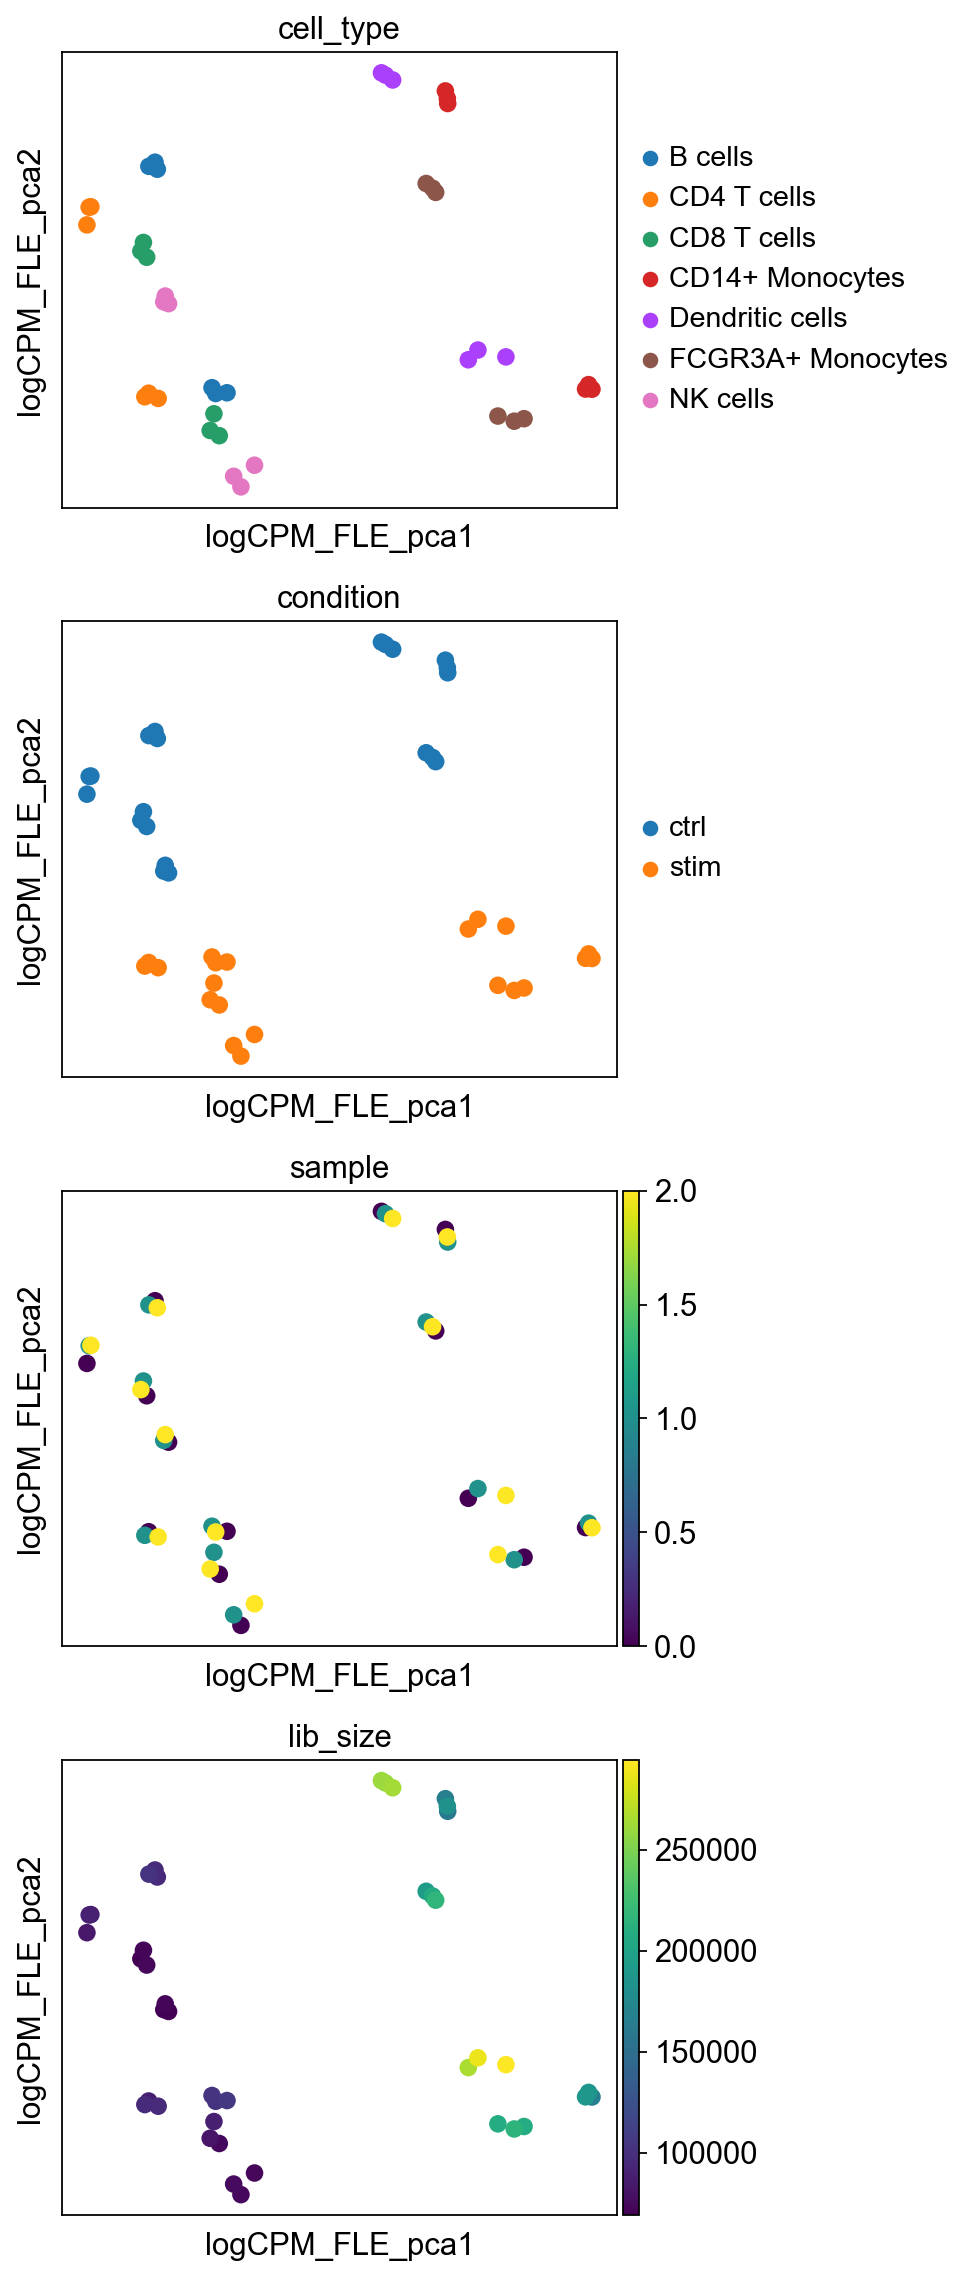

In [51]:
sc.pl.embedding(pb_data, "logCPM_FLE_pca", color=pb_data.obs, ncols=1, size=250)

Here, "logCPM_FLE" denotes filtering for low expressed genes followed by $\log_2$CPM transformation. We can now clearly observe that PC1 captures cell type effect and PC2 captures the treatment effect, when low-expressed genes are removed and differences between library sizes are adjusted by $\log_2$CPM transformation. 

Since in this case study we are indeed interested in stimulation effect per cell type, and this variation is better preserved before gene filtering, we presented the enrichment test results on unfiltered data. 
In practice, filtering low abundance genes and computation of normalisation factors by `edgeR::calcNormFactors` are standard part of bulk RNA-seq analysis workflow. Should we have been interested in global effects of IFN stimulation, we should have used the filtered data. Additionally, one can note that `design <- model.matrix(~ 0 + lineage + group)` would take into account differences (that is baseline expression differences) between myeloid and lymphoid lineages, improving the separation of pseudo-bulk samples by IFN stimulation, possibly along PC1.  In this case study, we were interested in cell type-specific effects, hence we stayed with a model of data whereby the variability along PC1 is by cell type. The choice of design matrix has to be carefully considered to align with the biological question of interest. 

##### A note on the redundancy between gene sets and the performance of preranked and fry gene set tests 

Generally, there can be a large overlap between closely related gene sets. This overlap impacts the rank of the gene sets in the enrichment results and can compromise the final interpretation. For example, the cells in Kang et al. are treated with IFN-$\beta$. Therefore, one would expect to see the term REACTOME_INTERFERON_ALPHA_BETA_SIGNALING as the top ranked term. While this term is indeed the top rank term in the output of `fry`, in the output of `GSEA`  REACTOME_INTERFERON_SIGNALING is the top rank term. This term has a larger number of genes (52) compared to REACTOME_INTERFERON_ALPHA_BETA_SIGNALING (24 genes), and most of those genes are shared between the two terms. This illustrates another difference between preranked gene set tests such as `GSEA` and `fry`, in preventing the larger gene sets from dominating the enrichment results. The better performance of `fry` is due to more accurate estimation of gene expression variances, hence more sensitive DE gene results.

## Key Takeaways

- Normalise your data using standard scRNA-seq normalisation methods and filter gene sets with low gene coverage in your data prior to pathway analysis.
- Be aware of different types of gene set testing tests (i.e. competitive vs self-contained) and use one that suits your application.
- Be aware of differences between gene set enrichment and gene set activity inference. *GSEA* is the widely used gene set test in single-cell studies; Pagoda 2 is found to outperform other pathway activity scoring tools. If your datasets has complex experimental design, consider pseudo-bulk analysis with gene set tests implemented in *limma*, as they are compatible with the linear model framework can additionally account for inter-gene correlations. 

## Quiz

1. What is the difference between gene set enrichment tests and activity scoring?
2. Describe examples of settings where gene set tests should be used? Can you outline examples of settings where pathway activity scoring methods are applicable?
3. What are the two types of Null Hypotheses in gene set enrichment tests. Explain the difference between the two types.
4. What is the most important preprocessing step in pathway analysis? What are the consequences if it is not conducted properly?
5. Name one gene set testing and one gene set activity scoring algorithm and explain it briefly.

## Session info

In [52]:
%%R
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur 11.6.8

Matrix products: default
LAPACK: /Users/isaac/miniconda3/envs/pathway/lib/libopenblasp-r0.3.21.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
[1] stats4    tools     stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] SingleCellExperiment_1.16.0 SummarizedExperiment_1.24.0
 [3] Biobase_2.54.0              GenomicRanges_1.46.1       
 [5] GenomeInfoDb_1.30.1         IRanges_2.28.0             
 [7] S4Vectors_0.32.4            BiocGenerics_0.40.0        
 [9] MatrixGenerics_1.6.0        matrixStats_0.63.0         

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.9             locfit_1.5-9.6         edgeR_3.36.0          
 [4] lattice_0.20-45        bitops_1.0-7           grid_4.1.2            
 [7] zlibbioc_1.40.0        XVector_0.34.0         limma_3.50.1          
[10] Matrix_1.5-3           statmod_1.4

In [53]:
session_info.show()

## References

```{bibliography}
:filter: docname in docnames
:labelprefix: gspa
```

## Contributors

We gratefully acknowledge the contributions of:

### Authors

* Lukas Heumos
* Anastasia Litinetskaya
* Soroor Hediyeh-Zadeh

### Reviewers